In [1]:
# load the weighted_avg from data/
import pickle

with open('data/weighted_avg_sat.pkl', 'rb') as f:
    weighted_avg_sat = pickle.load(f)

with open('data/weighted_avg_sic.pkl', 'rb') as f:
    weighted_avg_sic = pickle.load(f)

with open('data/weighted_avg_pre.pkl', 'rb') as f:
    weighted_avg_pre = pickle.load(f)

# Rename the keys and merge

In [2]:
renamed_weighted_avg_sat = {f'sat {k}': v for k, v in weighted_avg_sat.items()}
renamed_weighted_avg_sic = {f'sic {k}': v for k, v in weighted_avg_sic.items()}
renamed_weighted_avg_pre = {f'pre {k}': v for k, v in weighted_avg_pre.items()}

# Initialize an empty dictionary
merged_dict = {}

# Merge the three dictionaries into one
merged_dict.update(renamed_weighted_avg_sat)
merged_dict.update(renamed_weighted_avg_sic)
merged_dict.update(renamed_weighted_avg_pre)


# Filter the classes

In [3]:
# Remove specified keys
merged_dict.pop('sat 2', None)  # None is the default value if the key is not found
merged_dict.pop('pre 0', None)
merged_dict.pop('sic 0', None)

array([0.03051254, 0.03046647, 0.03045482, 0.03045806, 0.03049705,
       0.03042479, 0.03041693, 0.03045219, 0.03047029, 0.03049891,
       0.03047847, 0.03036354, 0.0304276 , 0.03046899, 0.03048856,
       0.03049884, 0.03035459, 0.03045316, 0.03044886, 0.0303406 ,
       0.03049174, 0.0304134 , 0.03041736, 0.03034557, 0.03044792,
       0.03048694, 0.03037516, 0.03053767, 0.03043855, 0.03040392,
       0.03038303, 0.03036668, 0.03047898, 0.03050404, 0.03033443,
       0.0304286 , 0.03036649, 0.03042389, 0.03036048, 0.03037381,
       0.03041991, 0.03040205, 0.03043645, 0.03041834, 0.03028848,
       0.03051625, 0.03035413, 0.03038088, 0.03036469, 0.03040697,
       0.03038811, 0.03030915, 0.03039049, 0.0304234 , 0.03047339,
       0.03025666, 0.03040741, 0.03048763, 0.03031175, 0.03034587,
       0.03035273, 0.03040386, 0.03035108, 0.03040554, 0.03043098,
       0.03031815, 0.03035154, 0.03039969, 0.030296  , 0.03035304,
       0.03031167, 0.03044671, 0.03034104, 0.03034213, 0.03040

In [35]:
merged_dict['sat 0'].shape

(788,)

In [4]:
import numpy  as np

# Define your stadial and interstadial periods and labels
stadials = np.array([[0, 80], [185, 336], [439, 569], [672, 787]])
interstadials = np.array([[107, 160], [356, 408], [589, 642]])
stadial_labels = ['S1', 'S2', 'S3', 'S4']
interstadial_labels = ['IS1', 'IS2', 'IS3']


# crop the data corresponding to the S2

# Initialize an empty dictionary
cropped_dict = {}

# Crop the data corresponding to the S2
for key, value in merged_dict.items():
    cropped_dict[key] = value[185:336]

merged_dict= cropped_dict
merged_dict['sat 0'].shape

(151,)

# Normalize the data

In [19]:
# import numpy as np

# normalized_dict = {}

# for key, array in merged_dict.items():
#     mean = np.mean(array)
#     std = np.std(array)
#     normalized_array = (array - mean) / std
#     normalized_dict[key] = normalized_array


# merged_dict=normalized_dict

# PCMCI using mutual information

(<Figure size 640x480 with 8 Axes>,
 array([<Axes: ylabel='pre 1'>, <Axes: ylabel='pre 2'>,
        <Axes: ylabel='sat 0'>, <Axes: ylabel='sat 1'>,
        <Axes: ylabel='sat 3'>, <Axes: ylabel='sic 1'>,
        <Axes: ylabel='sic 2'>, <Axes: ylabel='sic 3'>], dtype=object))

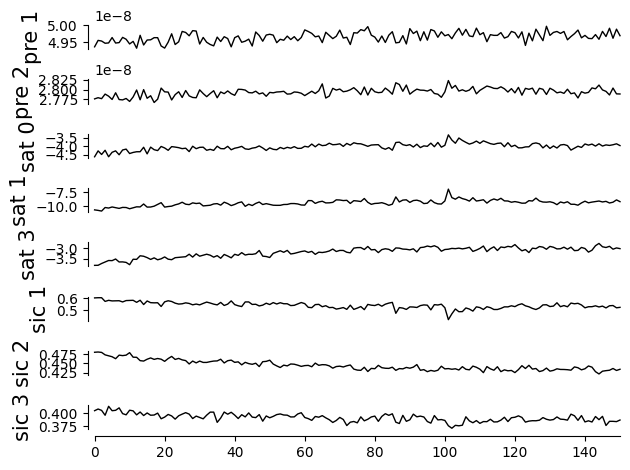

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import parcorr, gpdc, cmiknn

# Convert the dictionary to an array suitable for Tigramite's DataFrame
data_array = np.column_stack([merged_dict[key] for key in sorted(merged_dict.keys())])

# Create a Tigramite DataFrame object
var_names = [f"{k}" for k in sorted(merged_dict.keys())]
dataframe_TEMP = pp.DataFrame(data_array, datatime=np.arange(data_array.shape[0]), var_names=var_names)
tp.plot_timeseries(dataframe_TEMP,label_fontsize=15,tick_label_size=10)

In [17]:
cmi_knn = cmiknn.CMIknn(significance='shuffle_test', knn=0.1, shuffle_neighbors=5, transform='ranks', sig_samples=200)

pcmci = PCMCI(
    dataframe=dataframe_TEMP,
    cond_ind_test=cmi_knn,
    verbosity=1)

pcmci.verbosity = 1
tau_max=2
results = pcmci.run_pcmci(tau_min=1, tau_max=tau_max, pc_alpha=0.05, alpha_level=0.01)
# q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], tau_max=tau_max, fdr_method='fdr_bh')

# create a figure
fig, ax = plt.subplots(1, 1, figsize=(20, 20), dpi=100)
tp.plot_graph(
    fig_ax=(fig, ax),
    graph = results['graph'],
    val_matrix=results['val_matrix'],
    var_names=var_names,
    link_colorbar_label='MCI',
    node_colorbar_label='auto-MCI',
    link_label_fontsize=20,
    label_fontsize=20,
    tick_label_size=14,
    node_label_size=10,
    edge_ticks=0.5,
    node_ticks=0.5,
    node_size=0.2
    )


##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
independence test = cmi_knn
tau_min = 1
tau_max = 2
pc_alpha = [0.05]
max_conds_dim = None
max_combinations = 1




In [ ]:
from toolbox import post_processing_functions as ppf
import importlib
importlib.reload(ppf)


N = results['p_matrix'].shape[0]
var_names = var_names


results_text=ppf.print_significant_links(N, var_names, p_matrix=results['p_matrix'],
                                 val_matrix=results['val_matrix'],
                                 alpha_level=0.05)

causal_links = ppf.parse_results_to_dict(results_text, var_names)
causal_links

# causal_links = ppf.sort_causal_links_by_val(causal_links)
# causal_links

causal_links = ppf.clean_causal_links(causal_links)
causal_links  

    Variable pre 1 has 2 link(s):
        (sat 0 -1): pval = 0.00506 | val = -0.237
        (sat 3 -2): pval = 0.00668 | val =  0.229
    Variable pre 2 has 4 link(s):
        (sic 2 -1): pval = 0.00118 | val = -0.274
        (sat 3 -2): pval = 0.00831 | val = -0.225
        (sic 2 -2): pval = 0.01557 | val =  0.208
        (sat 1 -1): pval = 0.03400 | val =  0.178
    Variable sat 0 has 2 link(s):
        (sat 1 -1): pval = 0.00000 | val =  0.377
        (sic 2 -2): pval = 0.02895 | val = -0.190
    Variable sat 1 has 2 link(s):
        (sat 1 -1): pval = 0.00002 | val =  0.352
        (sat 0 -2): pval = 0.00113 | val =  0.274
    Variable sat 3 has 2 link(s):
        (pre 2 -1): pval = 0.00265 | val =  0.254
        (pre 1 -1): pval = 0.01101 | val =  0.214
    Variable sic 1 has 3 link(s):
        (sat 1 -1): pval = 0.00002 | val = -0.356
        (sat 1 -2): pval = 0.00657 | val =  0.230
        (sic 1 -2): pval = 0.03919 | val = -0.178
    Variable sic 2 has 3 link(s):
        (pre

{'pre 1': [{'cause': 'sat 0', 'lag': -1, 'pval': 0.00506, 'val': -0.237},
  {'cause': 'sat 3', 'lag': -2, 'pval': 0.00668, 'val': 0.229}],
 'pre 2': [{'cause': 'sic 2', 'lag': -1, 'pval': 0.00118, 'val': -0.274},
  {'cause': 'sat 3', 'lag': -2, 'pval': 0.00831, 'val': -0.225},
  {'cause': 'sic 2', 'lag': -2, 'pval': 0.01557, 'val': 0.208},
  {'cause': 'sat 1', 'lag': -1, 'pval': 0.034, 'val': 0.178}],
 'sat 0': [{'cause': 'sic 2', 'lag': -2, 'pval': 0.02895, 'val': -0.19}],
 'sat 1': [],
 'sat 3': [{'cause': 'pre 2', 'lag': -1, 'pval': 0.00265, 'val': 0.254},
  {'cause': 'pre 1', 'lag': -1, 'pval': 0.01101, 'val': 0.214}],
 'sic 1': [{'cause': 'sat 1', 'lag': -1, 'pval': 2e-05, 'val': -0.356},
  {'cause': 'sat 1', 'lag': -2, 'pval': 0.00657, 'val': 0.23}],
 'sic 2': [{'cause': 'pre 2', 'lag': -1, 'pval': 0.00016, 'val': -0.318},
  {'cause': 'pre 1', 'lag': -1, 'pval': 0.00039, 'val': -0.299}],
 'sic 3': [{'cause': 'sat 1', 'lag': -1, 'pval': 0.00341, 'val': -0.245},
  {'cause': 'pre 2'

In [ ]:
from toolbox import post_processing_functions as ppf
import importlib
importlib.reload(ppf)

causal_links4the_class = ppf.filter_single_class_causal_links(causal_links, 'sat 1')
causal_links4the_class


{'pre 2': [{'cause': 'sat 1', 'lag': -1, 'pval': 0.034, 'val': 0.178}],
 'sat 1': [],
 'sic 1': [{'cause': 'sat 1', 'lag': -1, 'pval': 2e-05, 'val': -0.356},
  {'cause': 'sat 1', 'lag': -2, 'pval': 0.00657, 'val': 0.23}],
 'sic 3': [{'cause': 'sat 1', 'lag': -1, 'pval': 0.00341, 'val': -0.245}]}

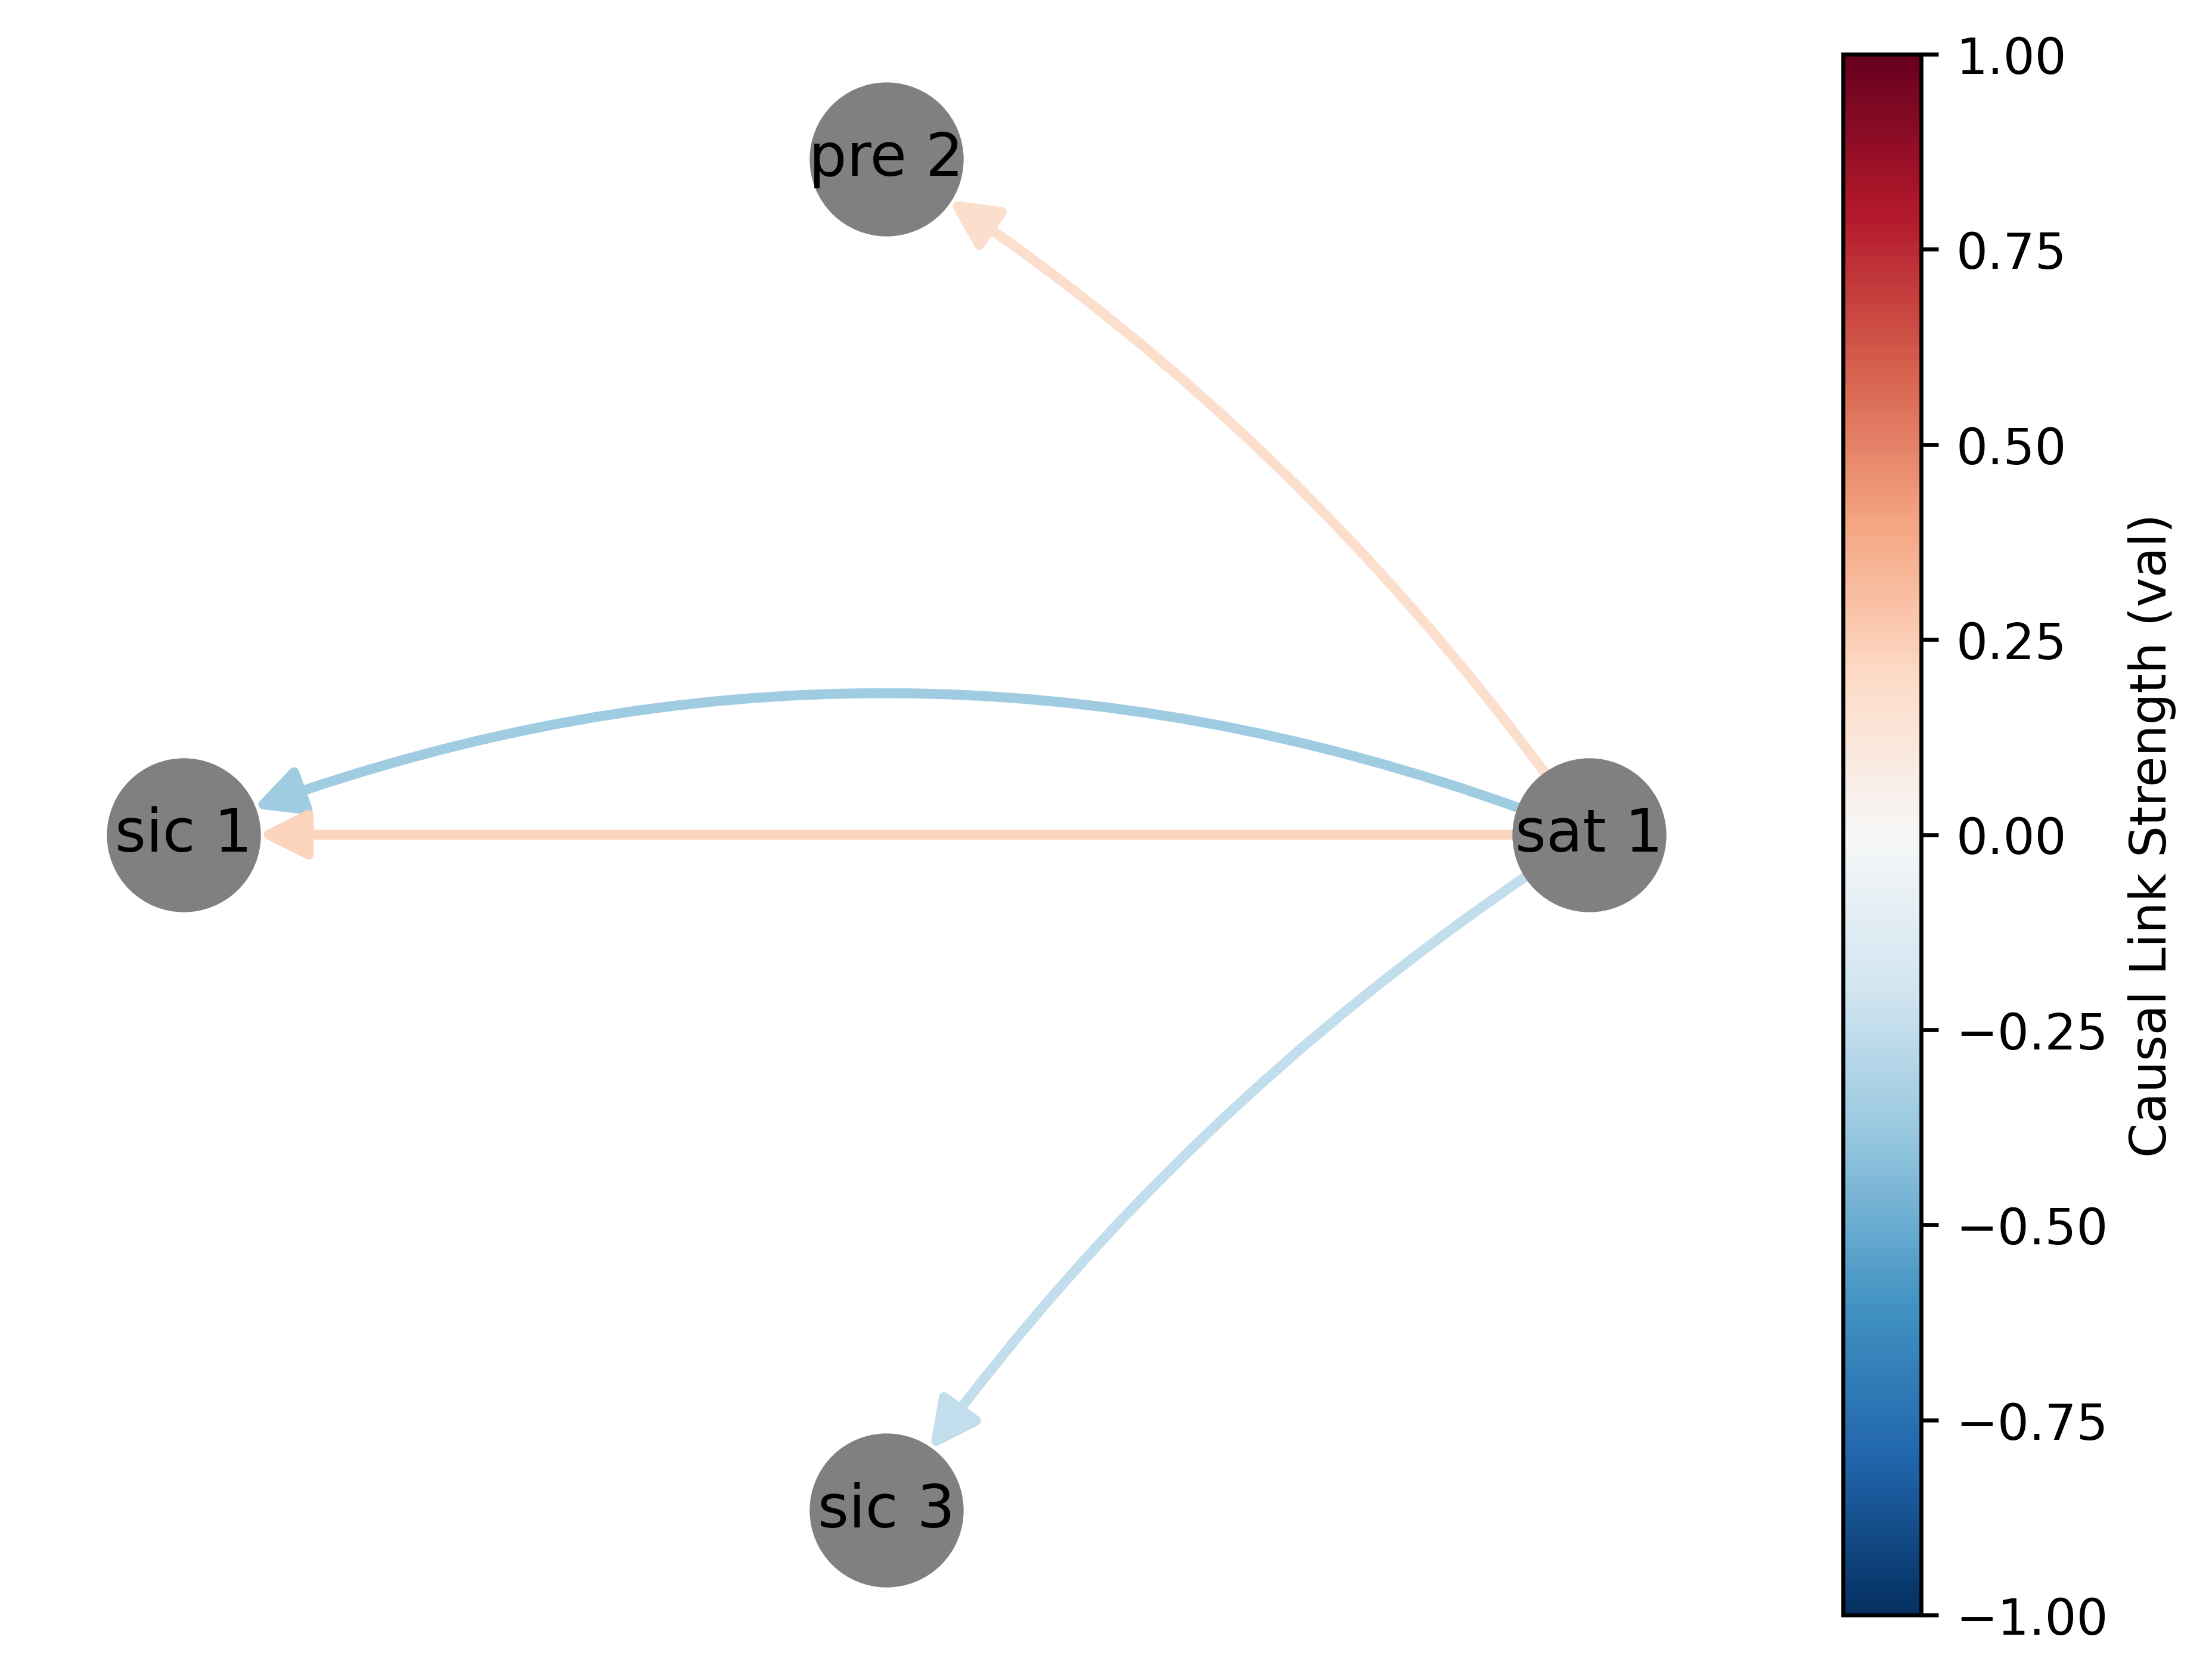

In [ ]:
from toolbox import post_processing_functions as ppf
import importlib
importlib.reload(ppf)


# Usage with the same causal_links as provided previously
ppf.plot_inter_var_causal_links(causal_links4the_class)

# PCMCI (using normalized data)

(<Figure size 640x480 with 8 Axes>,
 array([<Axes: ylabel='pre 1'>, <Axes: ylabel='pre 2'>,
        <Axes: ylabel='sat 0'>, <Axes: ylabel='sat 1'>,
        <Axes: ylabel='sat 3'>, <Axes: ylabel='sic 1'>,
        <Axes: ylabel='sic 2'>, <Axes: ylabel='sic 3'>], dtype=object))

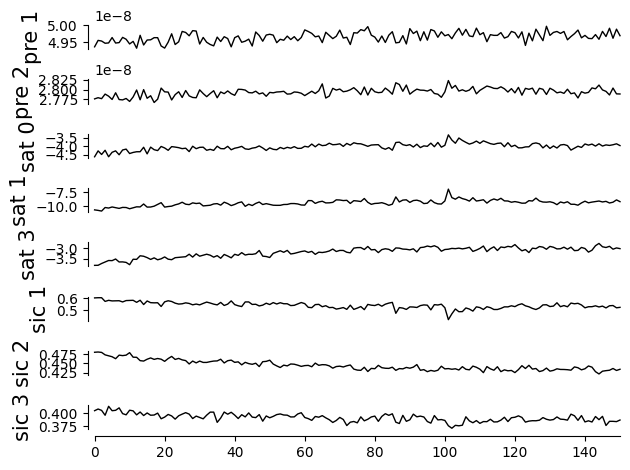

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests import parcorr, gpdc, cmiknn

# Convert the dictionary to an array suitable for Tigramite's DataFrame
data_array = np.column_stack([merged_dict[key] for key in sorted(merged_dict.keys())])

# Create a Tigramite DataFrame object
var_names = [f"{k}" for k in sorted(merged_dict.keys())]
dataframe_TEMP = pp.DataFrame(data_array, datatime=np.arange(data_array.shape[0]), var_names=var_names)
tp.plot_timeseries(dataframe_TEMP,label_fontsize=15,tick_label_size=10)


##
## Step 1: PC1 algorithm for selecting lagged conditions
##

Parameters:
independence test = par_corr
tau_min = 1
tau_max = 2
pc_alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
max_conds_dim = None
max_combinations = 1



## Resulting lagged parent (super)sets:

    Variable pre 1 has 2 link(s):
    [pc_alpha = 0.3]
        (sat 3 -2): max_pval = 0.27600, |min_val| =  0.091
        (sic 3 -1): max_pval = 0.29426, |min_val| =  0.088

    Variable pre 2 has 3 link(s):
    [pc_alpha = 0.3]
        (sic 3 -2): max_pval = 0.00792, |min_val| =  0.219
        (sat 1 -1): max_pval = 0.02563, |min_val| =  0.185
        (sic 2 -1): max_pval = 0.23956, |min_val| =  0.098

    Variable sat 0 has 7 link(s):
    [pc_alpha = 0.5]
        (sat 1 -1): max_pval = 0.00175, |min_val| =  0.257
        (sic 2 -2): max_pval = 0.05511, |min_val| =  0.161
        (sic 3 -2): max_pval = 0.11926, |min_val| =  0.132
        (sat 3 -2): max_pval = 0.19118, |min_val| =  0.110
        (sat 0 -2): max_pval = 0.30155, |mi

(<Figure size 2000x2000 with 1 Axes>, <Axes: >)

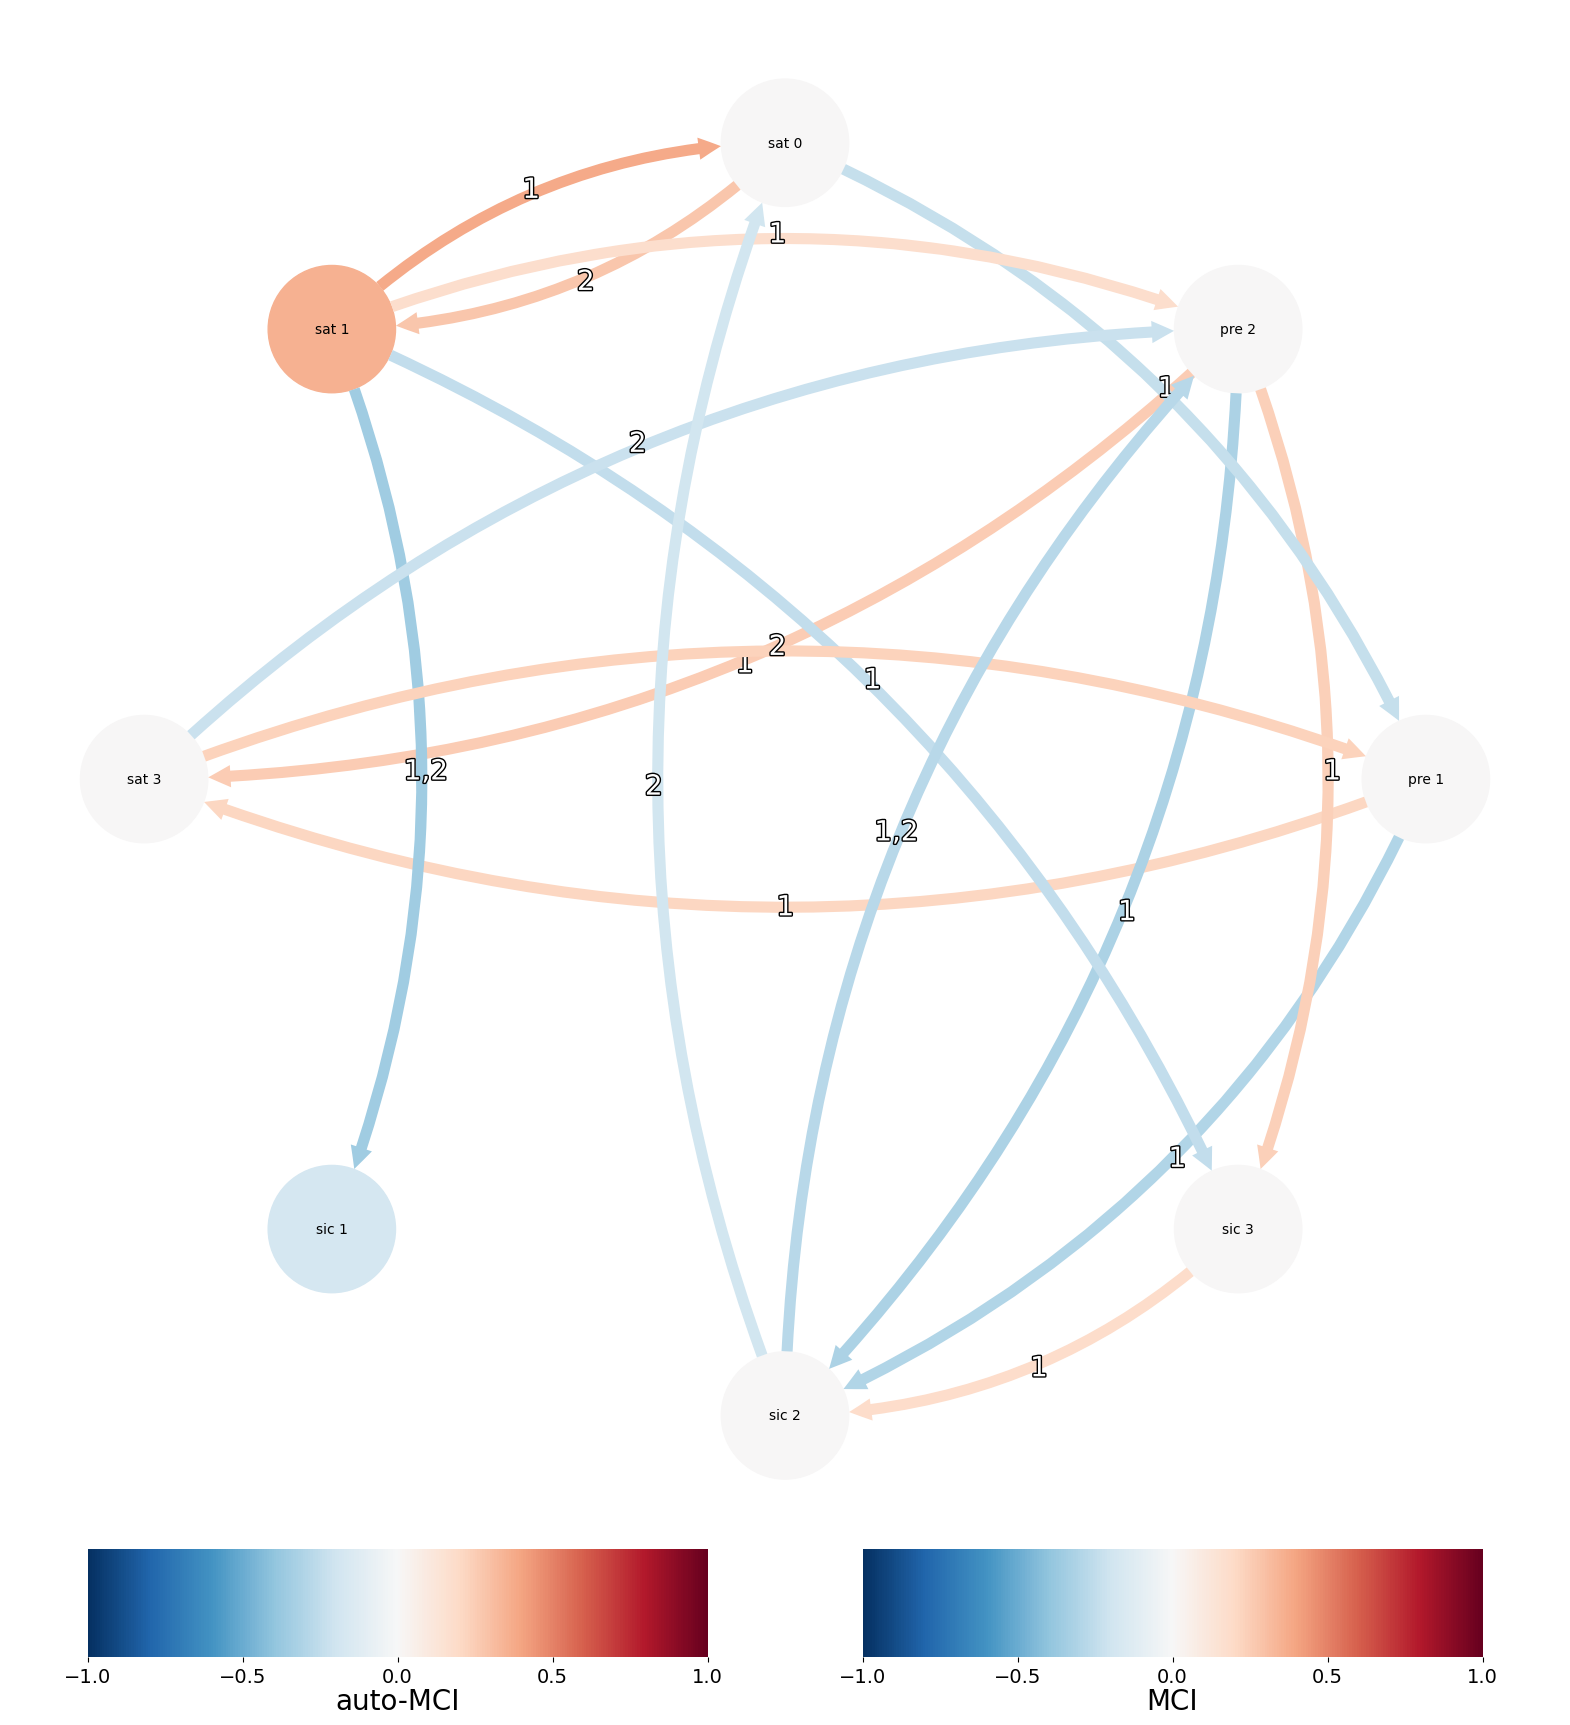

In [6]:
ParCorr = parcorr.ParCorr(significance='analytic')
pcmci = PCMCI(
    dataframe=dataframe_TEMP,
    cond_ind_test=ParCorr,
    verbosity=1)

pcmci.verbosity = 1
tau_max=2
results = pcmci.run_pcmci(tau_min=1, tau_max=tau_max, pc_alpha=None)
# q_matrix = pcmci.get_corrected_pvalues(p_matrix=results['p_matrix'], tau_max=tau_max, fdr_method='fdr_bh')

# create a figure
fig, ax = plt.subplots(1, 1, figsize=(20, 20), dpi=100)
tp.plot_graph(
    fig_ax=(fig, ax),
    graph = results['graph'],
    val_matrix=results['val_matrix'],
    var_names=var_names,
    link_colorbar_label='MCI',
    node_colorbar_label='auto-MCI',
    link_label_fontsize=20,
    label_fontsize=20,
    tick_label_size=14,
    node_label_size=10,
    edge_ticks=0.5,
    node_ticks=0.5,
    node_size=0.2
    )

In [23]:
results['p_matrix'].shape

(11, 11, 3)

In [7]:
from toolbox import post_processing_functions as ppf
import importlib
importlib.reload(ppf)


N = results['p_matrix'].shape[0]
var_names = var_names


results_text=ppf.print_significant_links(N, var_names, p_matrix=results['p_matrix'],
                                 val_matrix=results['val_matrix'],
                                 alpha_level=0.05)

causal_links = ppf.parse_results_to_dict(results_text, var_names)
causal_links

# causal_links = ppf.sort_causal_links_by_val(causal_links)
# causal_links

causal_links = ppf.clean_causal_links(causal_links)
causal_links

    Variable pre 1 has 2 link(s):
        (sat 0 -1): pval = 0.00506 | val = -0.237
        (sat 3 -2): pval = 0.00668 | val =  0.229
    Variable pre 2 has 4 link(s):
        (sic 2 -1): pval = 0.00118 | val = -0.274
        (sat 3 -2): pval = 0.00831 | val = -0.225
        (sic 2 -2): pval = 0.01557 | val =  0.208
        (sat 1 -1): pval = 0.03400 | val =  0.178
    Variable sat 0 has 2 link(s):
        (sat 1 -1): pval = 0.00000 | val =  0.377
        (sic 2 -2): pval = 0.02895 | val = -0.190
    Variable sat 1 has 2 link(s):
        (sat 1 -1): pval = 0.00002 | val =  0.352
        (sat 0 -2): pval = 0.00113 | val =  0.274
    Variable sat 3 has 2 link(s):
        (pre 2 -1): pval = 0.00265 | val =  0.254
        (pre 1 -1): pval = 0.01101 | val =  0.214
    Variable sic 1 has 3 link(s):
        (sat 1 -1): pval = 0.00002 | val = -0.356
        (sat 1 -2): pval = 0.00657 | val =  0.230
        (sic 1 -2): pval = 0.03919 | val = -0.178
    Variable sic 2 has 3 link(s):
        (pre

{'pre 1': [{'cause': 'sat 0', 'lag': -1, 'pval': 0.00506, 'val': -0.237},
  {'cause': 'sat 3', 'lag': -2, 'pval': 0.00668, 'val': 0.229}],
 'pre 2': [{'cause': 'sic 2', 'lag': -1, 'pval': 0.00118, 'val': -0.274},
  {'cause': 'sat 3', 'lag': -2, 'pval': 0.00831, 'val': -0.225},
  {'cause': 'sic 2', 'lag': -2, 'pval': 0.01557, 'val': 0.208},
  {'cause': 'sat 1', 'lag': -1, 'pval': 0.034, 'val': 0.178}],
 'sat 0': [{'cause': 'sic 2', 'lag': -2, 'pval': 0.02895, 'val': -0.19}],
 'sat 1': [],
 'sat 3': [{'cause': 'pre 2', 'lag': -1, 'pval': 0.00265, 'val': 0.254},
  {'cause': 'pre 1', 'lag': -1, 'pval': 0.01101, 'val': 0.214}],
 'sic 1': [{'cause': 'sat 1', 'lag': -1, 'pval': 2e-05, 'val': -0.356},
  {'cause': 'sat 1', 'lag': -2, 'pval': 0.00657, 'val': 0.23}],
 'sic 2': [{'cause': 'pre 2', 'lag': -1, 'pval': 0.00016, 'val': -0.318},
  {'cause': 'pre 1', 'lag': -1, 'pval': 0.00039, 'val': -0.299}],
 'sic 3': [{'cause': 'sat 1', 'lag': -1, 'pval': 0.00341, 'val': -0.245},
  {'cause': 'pre 2'

In [11]:
from toolbox import post_processing_functions as ppf
import importlib
importlib.reload(ppf)

causal_links4the_class = ppf.filter_single_class_causal_links(causal_links, 'sat 1')
causal_links4the_class


{'pre 2': [{'cause': 'sat 1', 'lag': -1, 'pval': 0.034, 'val': 0.178}],
 'sat 1': [],
 'sic 1': [{'cause': 'sat 1', 'lag': -1, 'pval': 2e-05, 'val': -0.356},
  {'cause': 'sat 1', 'lag': -2, 'pval': 0.00657, 'val': 0.23}],
 'sic 3': [{'cause': 'sat 1', 'lag': -1, 'pval': 0.00341, 'val': -0.245}]}

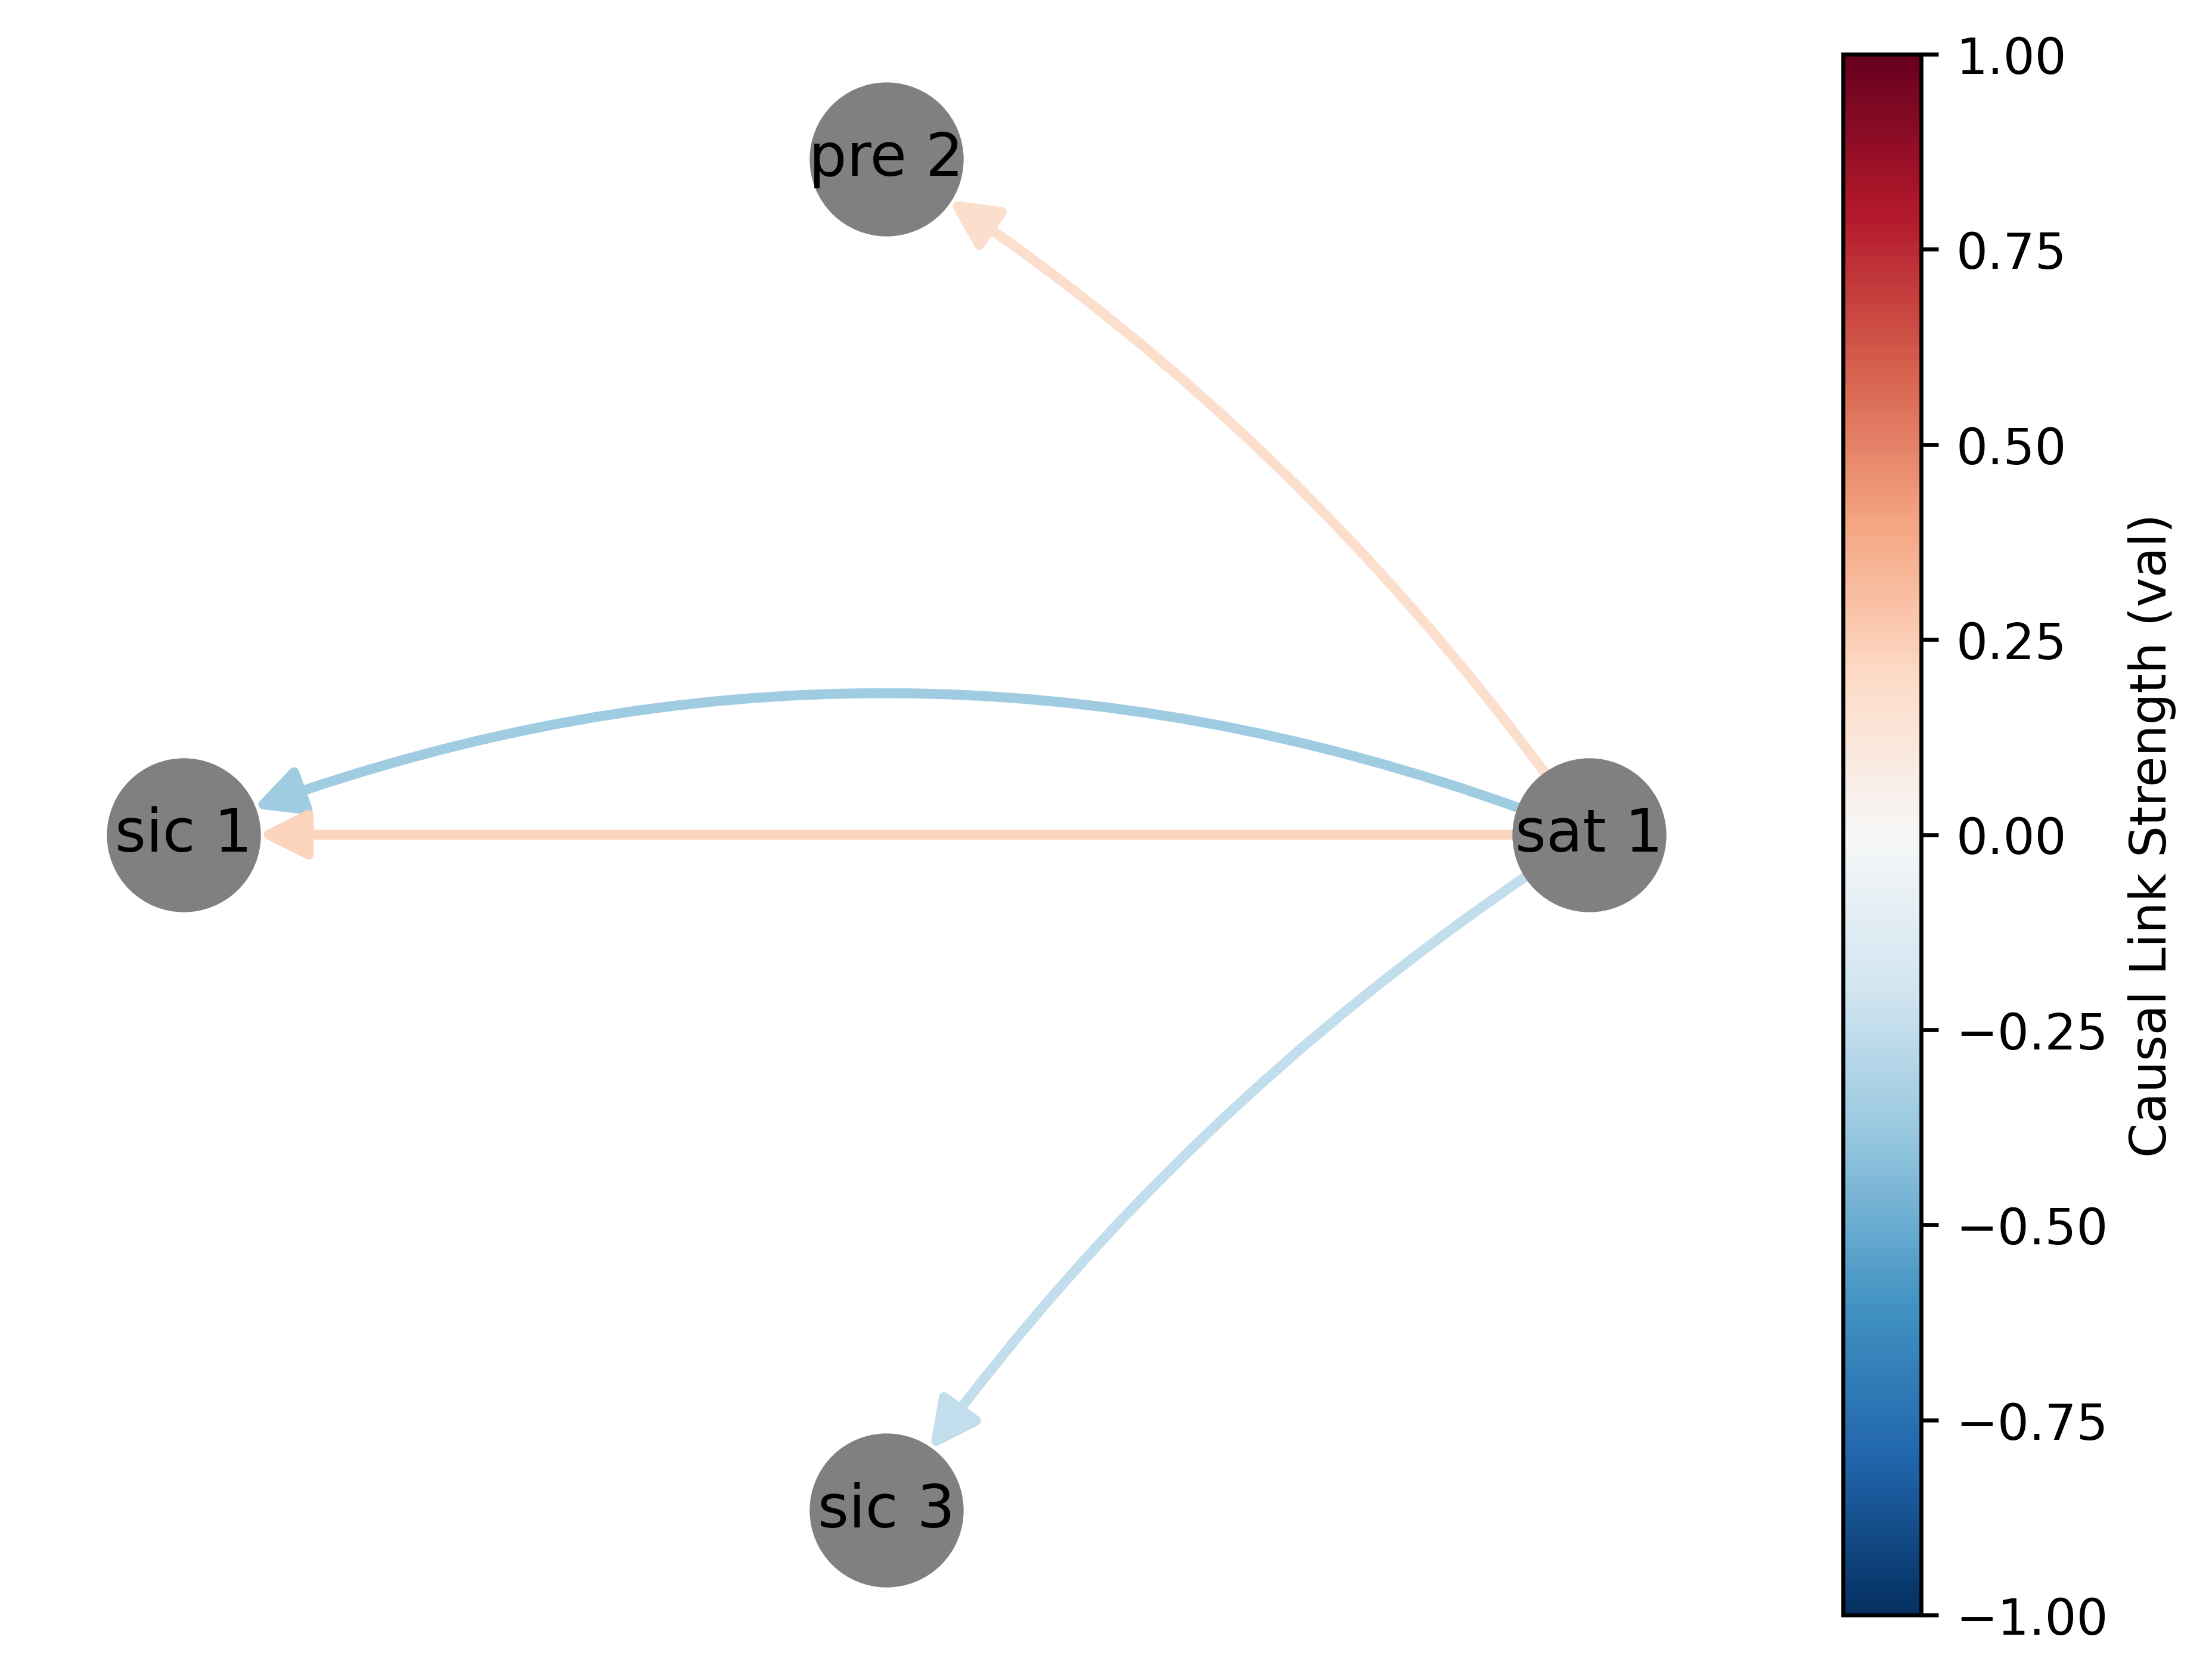

In [12]:
from toolbox import post_processing_functions as ppf
import importlib
importlib.reload(ppf)


# Usage with the same causal_links as provided previously
ppf.plot_inter_var_causal_links(causal_links4the_class)

In [13]:
# read ds_pre_GMM, ds_sat_GMM, ds_sic_GMM from data/, all are .nc files
import xarray as xr

ds_pre_GMM = xr.open_dataset('data/ds_pre_GMM.nc')
ds_sat_GMM = xr.open_dataset('data/ds_sat_GMM.nc')
ds_sic_GMM = xr.open_dataset('data/ds_sic_GMM.nc')

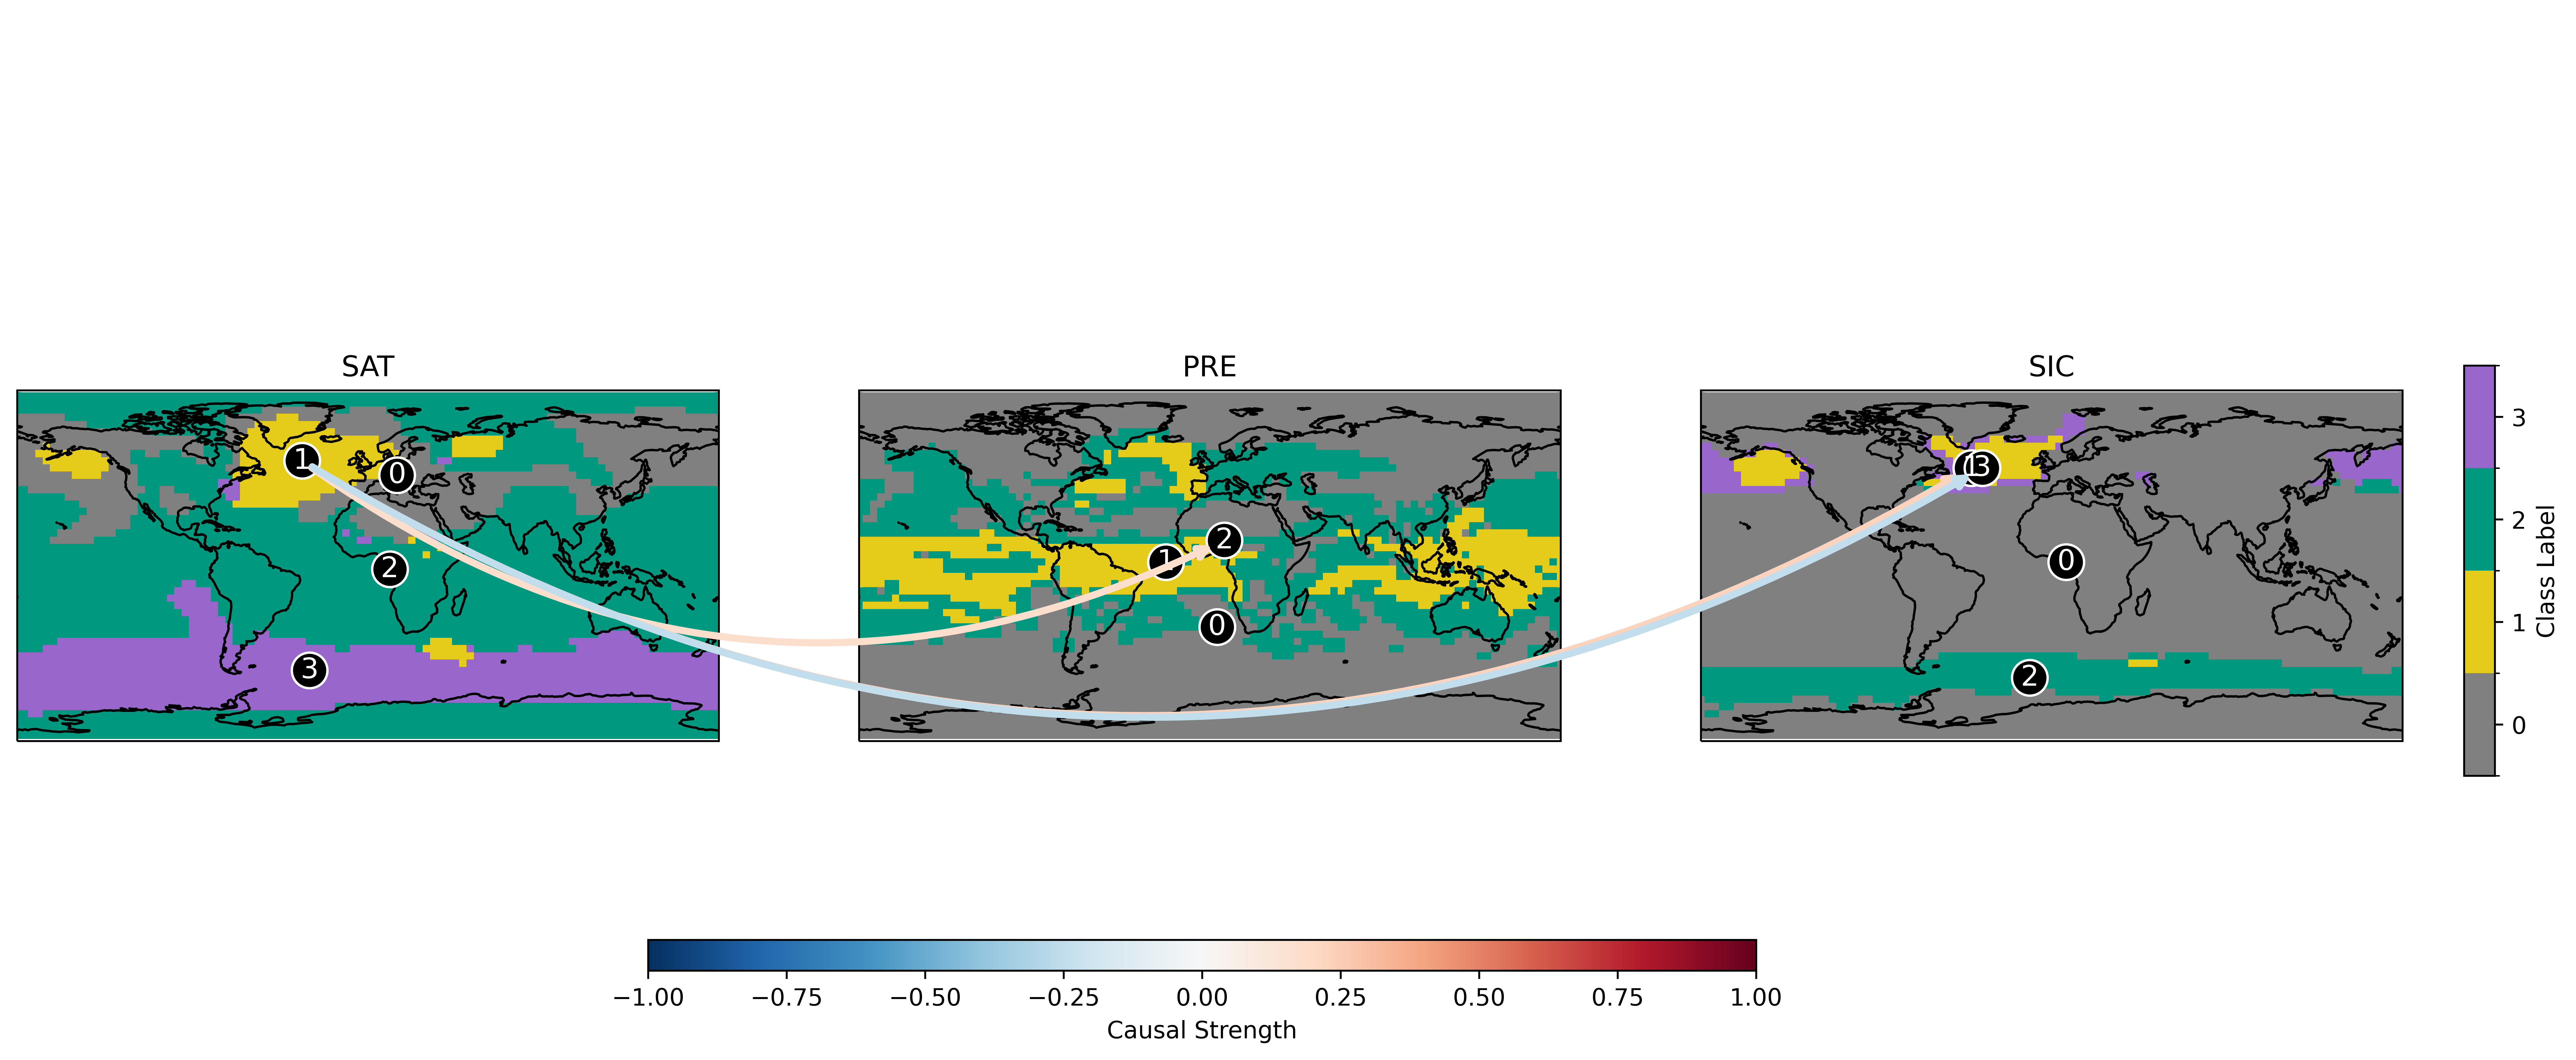

In [14]:
from toolbox import post_processing_functions as ppf
import importlib
importlib.reload(ppf)
 

# Example usage:
datasets = {
    'sat': xr.open_dataset('data/ds_sat_GMM.nc'),
    'pre': xr.open_dataset('data/ds_pre_GMM.nc'),
    'sic': xr.open_dataset('data/ds_sic_GMM.nc')
}

 
ppf.plot_vars_class_labels(datasets, causal_links4the_class, dpi=600)


# Clean the causal_links and remove the causal link from the same variable

In [46]:
from toolbox import post_processing_functions as ppf
import importlib
importlib.reload(ppf)


causal_links = ppf.clean_causal_links(causal_links)
causal_links



causal_links = ppf.filter_causal_links_by_val(causal_links, threshold=0.12)
causal_links

{'pre 0': [{'cause': 'sic 3', 'lag': -1, 'pval': 0.01278, 'val': -0.211}],
 'pre 1': [],
 'pre 2': [{'cause': 'sat 1', 'lag': -1, 'pval': 0.03173, 'val': 0.181},
  {'cause': 'sic 2', 'lag': -2, 'pval': 0.00413, 'val': 0.243},
  {'cause': 'sat 3', 'lag': -2, 'pval': 0.00332, 'val': -0.249},
  {'cause': 'sic 2', 'lag': -1, 'pval': 0.00076, 'val': -0.282}],
 'sat 0': [],
 'sat 1': [],
 'sat 2': [{'cause': 'sic 2', 'lag': -2, 'pval': 0.00517, 'val': -0.24}],
 'sat 3': [{'cause': 'pre 1', 'lag': -1, 'pval': 0.00982, 'val': 0.219},
  {'cause': 'sic 0', 'lag': -1, 'pval': 0.00367, 'val': -0.245},
  {'cause': 'sic 2', 'lag': -1, 'pval': 0.0019, 'val': -0.265}],
 'sic 0': [],
 'sic 1': [{'cause': 'sat 1', 'lag': -2, 'pval': 0.00309, 'val': 0.249},
  {'cause': 'sat 1', 'lag': -1, 'pval': 0.0, 'val': -0.395}],
 'sic 2': [{'cause': 'pre 2', 'lag': -1, 'pval': 0.00502, 'val': -0.237},
  {'cause': 'pre 1', 'lag': -1, 'pval': 0.00064, 'val': -0.285}],
 'sic 3': [{'cause': 'pre 2', 'lag': -1, 'pval': 

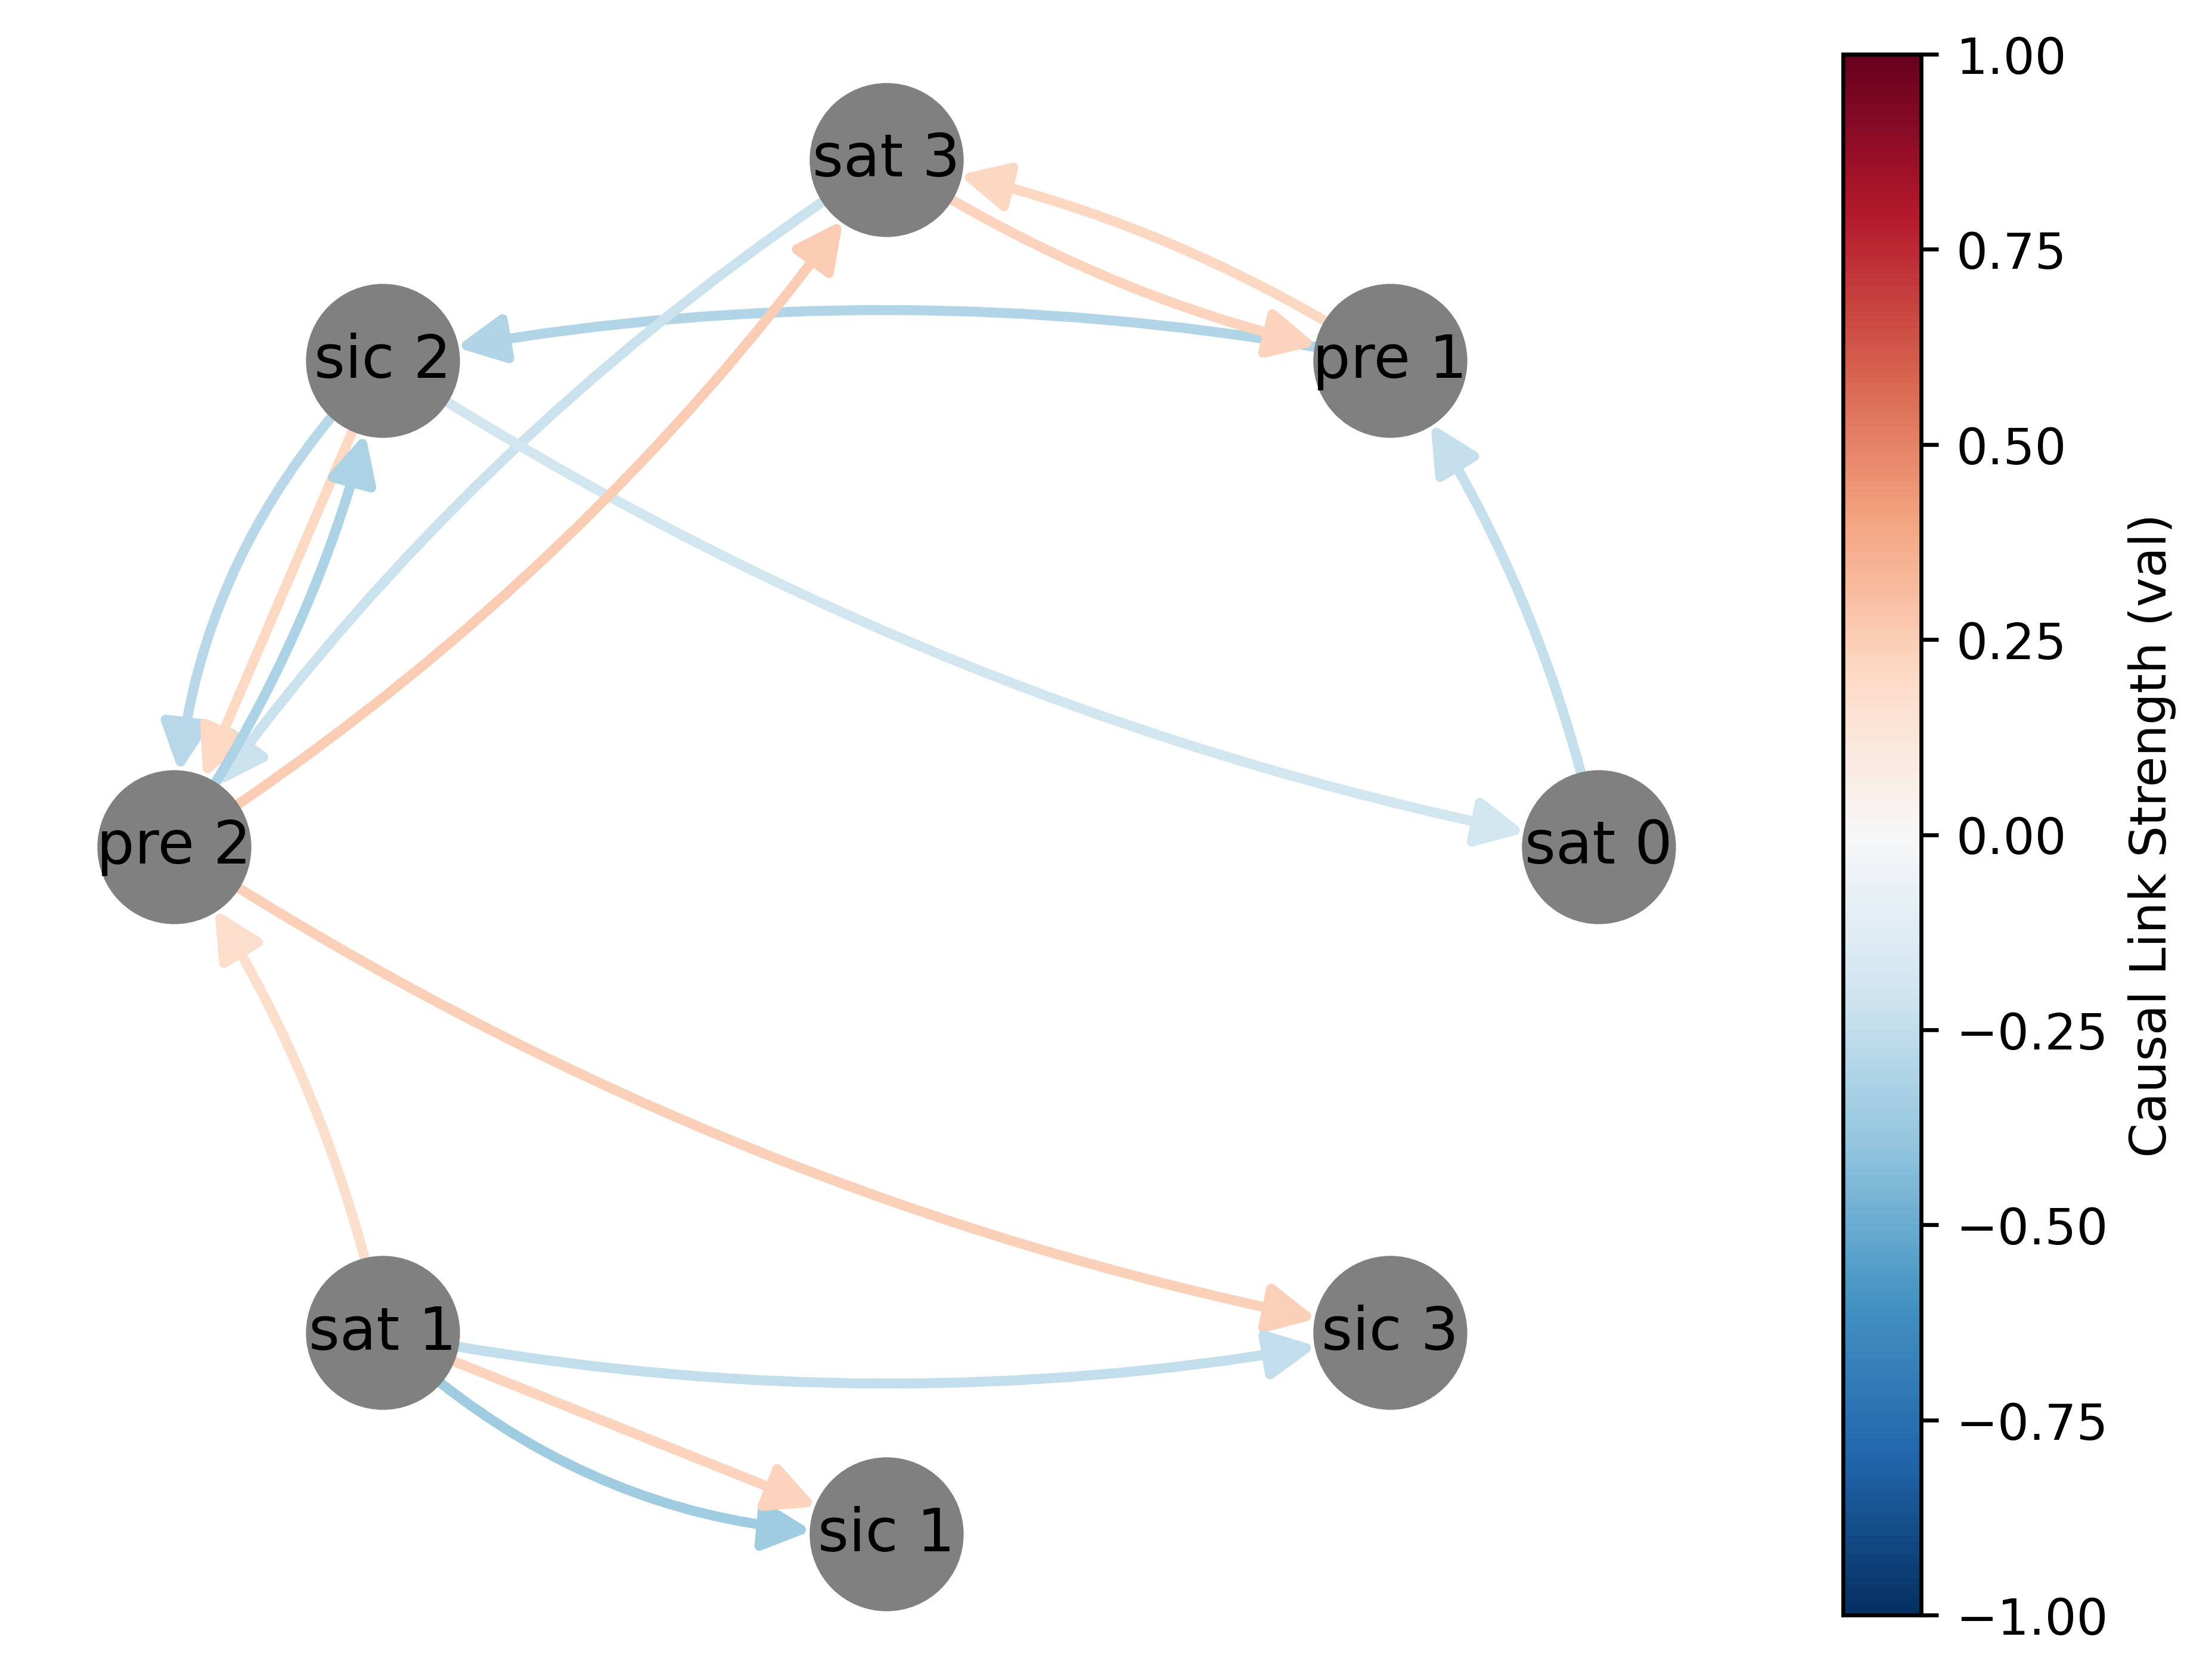

In [8]:
from toolbox import post_processing_functions as ppf
import importlib
importlib.reload(ppf)


# Usage with the same causal_links as provided previously
ppf.plot_inter_var_causal_links(causal_links)



# Load class labels

In [9]:
# read ds_pre_GMM, ds_sat_GMM, ds_sic_GMM from data/, all are .nc files
import xarray as xr

ds_pre_GMM = xr.open_dataset('data/ds_pre_GMM.nc')
ds_sat_GMM = xr.open_dataset('data/ds_sat_GMM.nc')
ds_sic_GMM = xr.open_dataset('data/ds_sic_GMM.nc')

In [49]:
ds_pre_GMM.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:                (age: 788, lat: 48, lon: 96)
Coordinates:
  * age                    (age) int32 0 10 20 30 40 ... 7840 7850 7860 7870
  * lat                    (lat) float64 -87.16 -83.48 -79.78 ... 83.48 87.16
  * lon                    (lon) float64 0.0 3.75 7.5 ... 348.8 352.5 356.2
Data variables:
    sat                    (age, lat, lon) float32 ...
    sat_centered           (age, lat, lon) float32 ...
    weight                 (lat) float64 ...
    sat_centered_weighted  (age, lat, lon) float64 ...
    class_label            (lat, lon) int64 ...>

In [50]:
ds_sat_GMM.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:                (age: 788, lat: 48, lon: 96)
Coordinates:
  * age                    (age) int32 0 10 20 30 40 ... 7840 7850 7860 7870
  * lat                    (lat) float64 -87.16 -83.48 -79.78 ... 83.48 87.16
  * lon                    (lon) float64 0.0 3.75 7.5 ... 348.8 352.5 356.2
Data variables:
    sat                    (age, lat, lon) float32 ...
    TREFHT_centered        (age, lat, lon) float32 ...
    weight                 (lat) float64 ...
    TREFHT_c_w             (age, lat, lon) float64 ...
    sat_centered           (age, lat, lon) float32 ...
    sat_centered_weighted  (age, lat, lon) float64 ...
    class_label            (lat, lon) int64 ...>

In [52]:
ds_sic_GMM.info

<bound method Dataset.info of <xarray.Dataset>
Dimensions:                (age: 788, lat: 48, lon: 96)
Coordinates:
  * age                    (age) int32 0 10 20 30 40 ... 7840 7850 7860 7870
  * lat                    (lat) float64 -87.16 -83.48 -79.78 ... 83.48 87.16
  * lon                    (lon) float64 0.0 3.75 7.5 ... 348.8 352.5 356.2
Data variables:
    sat                    (age, lat, lon) float32 ...
    sat_centered           (age, lat, lon) float32 ...
    weight                 (lat) float64 ...
    sat_centered_weighted  (age, lat, lon) float64 ...
    class_label            (lat, lon) int64 ...>

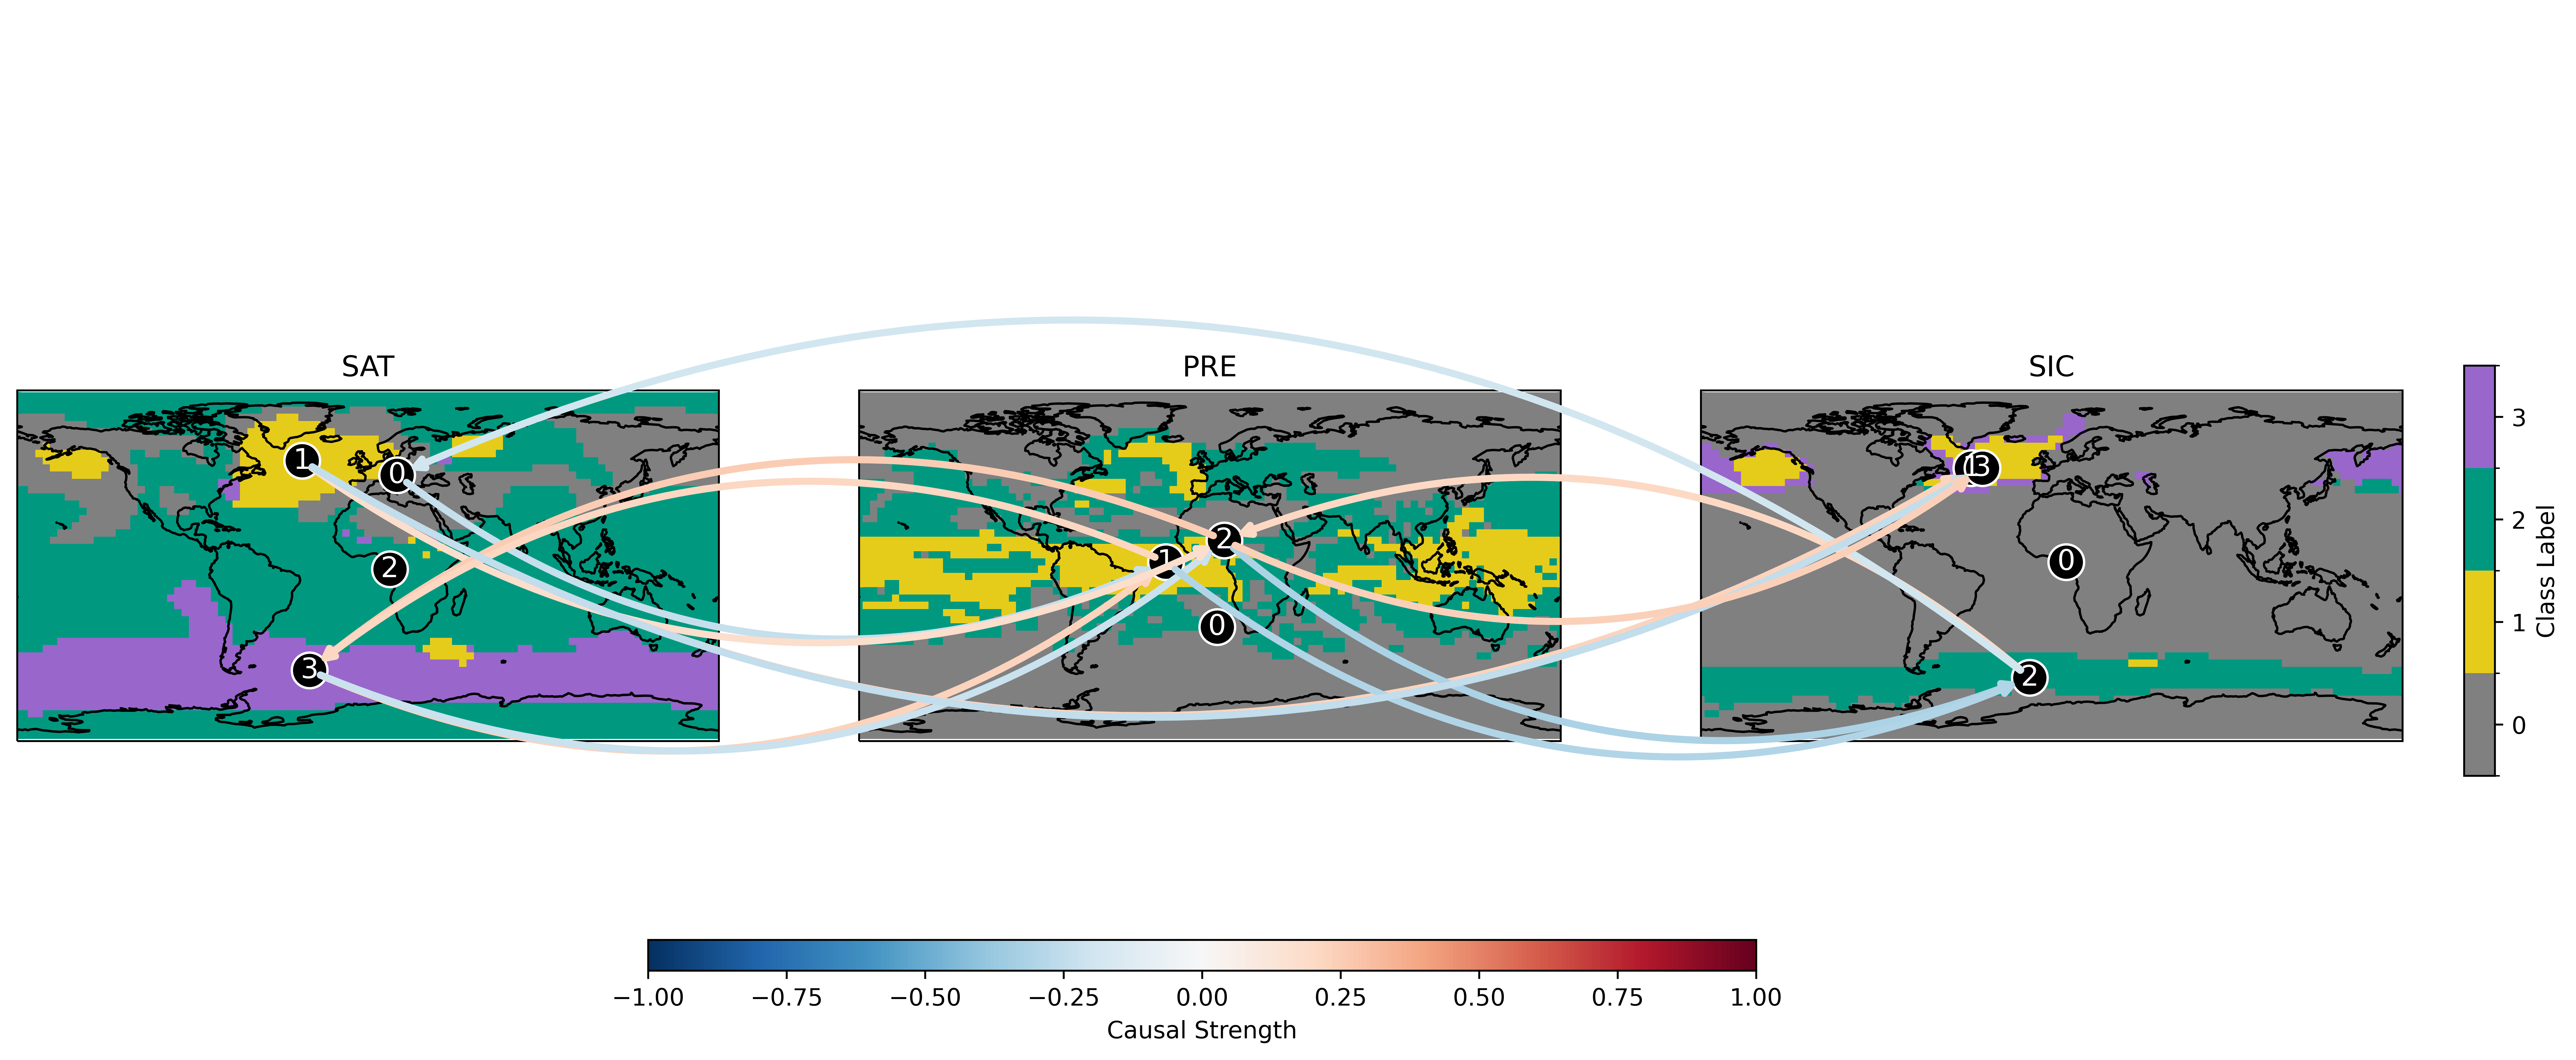

In [10]:
from toolbox import post_processing_functions as ppf
import importlib
importlib.reload(ppf)
 

# Example usage:
datasets = {
    'sat': xr.open_dataset('data/ds_sat_GMM.nc'),
    'pre': xr.open_dataset('data/ds_pre_GMM.nc'),
    'sic': xr.open_dataset('data/ds_sic_GMM.nc')
}
 
ppf.plot_vars_class_labels(datasets, causal_links, dpi=600)
